In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from scipy.sparse import csr_matrix

In [2]:
wiki = pd.read_csv('people_wiki.csv')
wiki.head(3)

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...


In [3]:
wiki.describe()

,URI,name,text
count,59071,59071,59071
unique,59071,59070,59071
top,<http://dbpedia.org/resource/Tammy_Rae_Carland>,author),dylan mika born 17 april 1972 in auckland is a...
freq,1,2,1


In [4]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

In [5]:
word_count = load_sparse_csr('people_wiki_word_count.npz')
word_count

<59071x547979 sparse matrix of type '<class 'numpy.int64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [6]:
with open('people_wiki_map_index_to_word.json') as people_wiki_map_index_to_word:    
    map_index_to_word = json.load(people_wiki_map_index_to_word)
len(map_index_to_word)

547979

In [7]:
from sklearn.neighbors import NearestNeighbors

In [8]:
model = NearestNeighbors(metric='euclidean', algorithm='brute')
model.fit(word_count)

NearestNeighbors(algorithm='brute', metric='euclidean')

In [9]:
print(wiki[wiki['name'] == 'Barack Obama'].index[0])

35817


In [10]:
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10)
print(distances)
print(indices)

[[ 0.         33.07567082 34.39476704 36.15245497 36.16628264 36.33180425
  36.40054945 36.49657518 36.63331817 36.95943723]]
[[35817 24478 28447 35357 14754 13229 31423 22745 36364  9210]]


In [11]:
print('ID     Name     Distance')
for i in range(10):
    print(str(indices[0][i]) + '  ' + str(wiki.loc[indices[0][i], 'name']) + '  ' + str(distances[0][i]))

ID     Name     Distance
35817  Barack Obama  0.0
24478  Joe Biden  33.075670817082454
28447  George W. Bush  34.39476704383968
35357  Lawrence Summers  36.15245496505044
14754  Mitt Romney  36.16628264005025
13229  Francisco Barrio  36.3318042491699
31423  Walter Mondale  36.40054944640259
22745  Wynn Normington Hugh-Jones  36.49657518178932
36364  Don Bonker  36.6333181680284
9210  Andy Anstett  36.959437225152655


In [12]:
neighbors = pd.DataFrame(data={'distance':distances.flatten()},index=indices.flatten())
print(wiki.join(neighbors).sort_values(by='distance')[['name','distance']][0:10])

                             name   distance
35817                Barack Obama   0.000000
24478                   Joe Biden  33.075671
28447              George W. Bush  34.394767
35357            Lawrence Summers  36.152455
14754                 Mitt Romney  36.166283
13229            Francisco Barrio  36.331804
31423              Walter Mondale  36.400549
22745  Wynn Normington Hugh-Jones  36.496575
36364                  Don Bonker  36.633318
9210                 Andy Anstett  36.959437


In [13]:
from past.builtins import xrange

In [14]:
def unpack_dict(matrix, map_index_to_word):
    #table = list(map_index_to_word.sort('index')['category'])
    # if you're not using SFrame, replace this line with
    table = sorted(map_index_to_word, key=map_index_to_word.get)
    
    
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                 data[indptr[i]:indptr[i+1]].tolist())} \
               for i in xrange(num_doc) ]

wiki['word_count'] = unpack_dict(word_count, map_index_to_word)

In [15]:
wiki.head(3)

,URI,name,text,word_count
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'..."


In [16]:
name = 'Barack Obama'
row = wiki[wiki['name'] == name]
dic = row['word_count'].iloc[0]
word_count_ = pd.DataFrame(dic.items(), columns=['word','count'], index=None)
print(word_count_.head(4))

             word  count
0           husen      1
1       2012obama      1
2  laureateduring      1
3       normalize      1


In [17]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    dic = row['word_count'].iloc[0]
    word_count_ = pd.DataFrame(dic.items(), columns=['word','count'])
    word_count_table = word_count_.sort_values(by='count', ascending=False)
    #word_count_table = word_count_table.fillna(0)
    #word_count_table = row[['word_count']].stack('word_count', new_column_name=['word','count'])
    return word_count_table #word_count_table.sort('count', ascending=False)

obama_words = top_words('Barack Obama')
print(obama_words.head(10))
print('\n')
barrio_words = top_words('Francisco Barrio')
print(barrio_words.head(10))

      word  count
272    the     40
270     in     30
271    and     21
269     of     18
266     to     14
258    his     11
71   obama      9
138    act      8
260     he      7
268      a      7


          word  count
224        the     36
221         of     24
223        and     18
222         in     17
212         he     10
218         to      9
19   chihuahua      7
220          a      6
111   governor      6
210        his      5


In [18]:
combined_words = obama_words.set_index('word').join(barrio_words.set_index('word'), lsuffix='_obama', rsuffix='_barrio')
combined_words.head(10)

,count_obama,count_barrio
word,,
the,40,36.0
in,30,17.0
and,21,18.0
of,18,24.0
to,14,9.0
his,11,5.0
obama,9,NaN
act,8,NaN
he,7,10.0


In [19]:
common_words = set(['the', 'in', 'and', 'of', 'to'])  # YOUR CODE HERE

def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector.keys())   # YOUR CODE HERE
    # return True if common_words is a subset of unique_words
    # return False otherwise
    #print unique_words
    return common_words.issubset(unique_words)  # YOUR CODE HERE

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

# use has_top_words column to answer the quiz question
wiki.head(10) # YOUR CODE HERE

,URI,name,text,word_count,has_top_words
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...",True
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...",True
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...",True
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,"{'fantasticrottensteiner': 1, 'waidmannsfeld':...",True
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...,"{'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...",False
5,<http://dbpedia.org/resource/Sam_Henderson>,Sam Henderson,sam henderson born october 18 1969 is an ameri...,"{'historyhenderson': 1, 'onteora': 1, '1991hen...",False
6,<http://dbpedia.org/resource/Aaron_LaCrate>,Aaron LaCrate,aaron lacrate is an american music producer re...,"{'pellatfinet': 1, 'lacrates': 1, 'baltimoreaa...",True
7,<http://dbpedia.org/resource/Trevor_Ferguson>,Trevor Ferguson,trevor ferguson aka john farrow born 11 novemb...,"{'2014city': 1, 'kinkajou': 1, 'bunkhousesin':...",True
8,<http://dbpedia.org/resource/Grant_Nelson>,Grant Nelson,grant nelson born 27 april 1971 in london also...,"{'garagehe': 1, 'hardcores': 1, 'wishdokta': 3...",True
9,<http://dbpedia.org/resource/Cathy_Caruth>,Cathy Caruth,cathy caruth born 1955 is frank h t rhodes pro...,"{'caruths': 1, 'deborash': 1, '173182': 1, 'ca...",True


In [20]:
print(len(wiki[wiki['has_top_words'] == True]))

56066


In [21]:
from sklearn.metrics.pairwise import euclidean_distances

print(euclidean_distances(word_count[wiki[wiki['name'] == 'Barack Obama'].index[0]], word_count[wiki[wiki['name'] == 'George W. Bush'].index[0]]))
print(euclidean_distances(word_count[wiki[wiki['name'] == 'Barack Obama'].index[0]], word_count[wiki[wiki['name'] == 'Joe Biden'].index[0]]))
print(euclidean_distances(word_count[wiki[wiki['name'] == 'George W. Bush'].index[0]], word_count[wiki[wiki['name'] == 'Joe Biden'].index[0]]))

[[34.39476704]]
[[33.07567082]]
[[32.75667871]]


In [22]:
wc_BO = word_count[wiki[wiki['name'] == 'Barack Obama'].index[0]].tocoo()
wc_GB = word_count[wiki[wiki['name'] == 'George W. Bush'].index[0]].tocoo()
wc = list(set(wc_BO.col) & set(wc_GB.col))
lista_valores = {}
for i, j, z in zip(wc_BO.row, wc_BO.col, wc_BO.data):
    if j in wc:
        lista_valores[j] = z
        
dicionario = dict(sorted(lista_valores.items(), key=lambda item: item[1]))
lista = list(dicionario.keys())
lista[len(lista)-10:len(lista)]

[547969,
 547966,
 547974,
 547084,
 547964,
 547972,
 547975,
 547977,
 547976,
 547978]

In [23]:
my_dict2 = {y:x for x,y in map_index_to_word.items()}
for i in lista[len(lista)-10:len(lista)]:
    print(my_dict2[i])

as
he
a
act
his
to
of
and
in
the


In [24]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')

In [25]:
wiki['tf_idf'] = unpack_dict(tf_idf, map_index_to_word)

In [27]:
wiki.head(3)

,URI,name,text,word_count,has_top_words,tf_idf
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...",True,"{'brisbaneafter': 10.986495389225194, 'edflhe'..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...",True,"{'maladaptation': 10.986495389225194, 'phasede..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...",True,"{'germanyover': 10.986495389225194, 'bluesgosp..."


In [28]:
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', metric='euclidean')

In [29]:
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=10)

In [31]:
neighbors = pd.DataFrame(data={'distance':distances.flatten()}, index=indices.flatten())
print(wiki.join(neighbors).sort_values(by='distance')[['name','distance']][0:10])

                          name    distance
35817             Barack Obama    0.000000
7914             Phil Schiliro  106.861014
46811            Jeff Sessions  108.871674
44681   Jesse Lee (politician)  109.045698
38376           Samantha Power  109.108106
6507              Bob Menendez  109.781867
38714  Eric Stern (politician)  109.957788
44825           James A. Guest  110.413889
44368     Roland Grossenbacher  110.470609
33417            Tulsi Gabbard  110.696998


In [33]:
def top_words_tf_idf(name):
    row = wiki[wiki['name'] == name]
    row = wiki[wiki['name'] == name]
    dic = row['tf_idf'].iloc[0]
    word_weight_ = pd.DataFrame(dic.items(), columns=['word','weight'])
    word_weight_table = word_weight_.sort_values(by=['weight'], ascending=False)
    #word_count_table = row[['word_count']].stack('word_count', new_column_name=['word','count'])
    return word_weight_table #word_count_table.sort('count', ascending=False)

obama_tf_idf = top_words_tf_idf('Barack Obama')
print(obama_tf_idf.head(10))

schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
print(schiliro_tf_idf.head(10))

            word     weight
71         obama  43.295653
138          act  27.678223
97          iraq  17.747379
129      control  14.887061
191          law  14.722936
69       ordered  14.533374
155     military  13.115933
105  involvement  12.784385
104     response  12.784385
166   democratic  12.410689
               word     weight
1          schiliro  21.972991
42            staff  15.856442
17    congressional  13.547088
0   daschleschiliro  10.986495
13            obama   9.621256
2            waxman   9.040585
82        president   9.033587
3          2014from   8.683910
65              law   7.361468
33       consultant   6.913104


In [48]:
lista_schiliro = schiliro_tf_idf['word'].to_list()

lista_conjunta = []
for index, row in obama_tf_idf.iterrows():
    if row['word'] in lista_schiliro:
        lista_conjunta.append(row['word'])

len(lista_conjunta)

47

In [52]:
common_words = set(lista_conjunta[0:5])  # YOUR CODE HERE

def has_top_words(word_count_vector):
    # extract the keys of word_count_vector and convert it to a set
    unique_words = set(word_count_vector.keys())   # YOUR CODE HERE
    # return True if common_words is a subset of unique_words
    # return False otherwise
    #print unique_words
    return common_words.issubset(unique_words)  # YOUR CODE HERE

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

# use has_top_words column to answer the quiz question
wiki.head(3) # YOUR CODE HERE

,URI,name,text,word_count,has_top_words,tf_idf
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...,"{'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...",False,"{'brisbaneafter': 10.986495389225194, 'edflhe'..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,"{'maladaptation': 1, 'phasedelay': 1, '25hour'...",False,"{'maladaptation': 10.986495389225194, 'phasede..."
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...,"{'germanyover': 1, 'bluesgospel': 1, 'harpdog'...",False,"{'germanyover': 10.986495389225194, 'bluesgosp..."


In [55]:
wiki[wiki['has_top_words'] == True].describe()

,URI,name,text,word_count,has_top_words,tf_idf
count,14,14,14,14,14,14
unique,14,14,14,14,1,14
top,<http://dbpedia.org/resource/Hillary_Rodham_Cl...,Sarah Sewall,sheila nix is an american political strategist...,"{'bushkerry': 1, 'crimesafter': 1, '943': 1, '...",True,"{'bushkerry': 10.986495389225194, 'crimesafter..."
freq,1,1,1,1,14,1


In [56]:
print(euclidean_distances(tf_idf[wiki[wiki['name'] == 'Barack Obama'].index[0]], tf_idf[wiki[wiki['name'] == 'Joe Biden'].index[0]]))

[[123.29745601]]


In [59]:
# Comptue length of all documents
def compute_length(row):
    #print row['text'].split(' ')
    return len(row['text'].split(' '))
wiki['length'] = wiki.apply(compute_length, axis=1)

In [60]:
# Compute 100 nearest neighbors and display their lengths
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = pd.DataFrame(data={'distance':distances.flatten()}, index=indices.flatten())
#print neighbors.head(2)
nearest_neighbors_euclidean = wiki.join(neighbors).sort_values(by='distance')[['name', 'length', 'distance']]
print(nearest_neighbors_euclidean.head(10))

                          name  length    distance
35817             Barack Obama     540    0.000000
7914             Phil Schiliro     208  106.861014
46811            Jeff Sessions     230  108.871674
44681   Jesse Lee (politician)     216  109.045698
38376           Samantha Power     310  109.108106
6507              Bob Menendez     220  109.781867
38714  Eric Stern (politician)     255  109.957788
44825           James A. Guest     215  110.413889
44368     Roland Grossenbacher     201  110.470609
33417            Tulsi Gabbard     228  110.696998


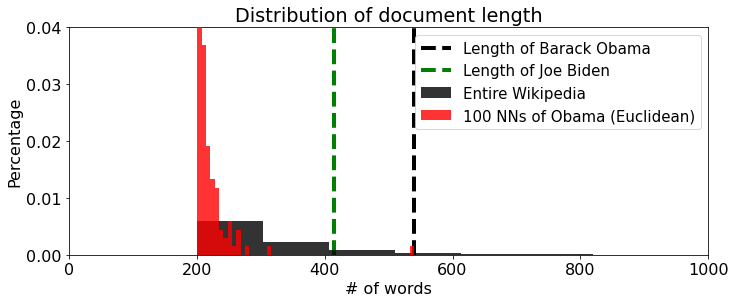

In [64]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density = True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'][:100], 50, color='r', edgecolor='None', histtype='stepfilled', density = True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=wiki['length'][wiki.index[wiki['name'] == 'Barack Obama']].tolist()[0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki.index[wiki['name'] == 'Joe Biden']].tolist()[0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [66]:
model2_tf_idf = NearestNeighbors(algorithm='brute', metric='cosine')
model2_tf_idf.fit(tf_idf)
distances, indices = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)
neighbors = pd.DataFrame(data={'distance':distances.flatten()}, index=indices.flatten())
nearest_neighbors_cosine = wiki.join(neighbors)[['name', 'length', 'distance']].sort_values(by='distance')
print(nearest_neighbors_cosine.head(10))

                          name  length  distance
35817             Barack Obama     540  0.000000
24478                Joe Biden     414  0.703139
38376           Samantha Power     310  0.742982
57108   Hillary Rodham Clinton     580  0.758358
38714  Eric Stern (politician)     255  0.770561
46140             Robert Gibbs     257  0.784678
6796               Eric Holder     232  0.788039
44681   Jesse Lee (politician)     216  0.790926
18827             Henry Waxman     279  0.798323
2412           Joe the Plumber     217  0.799466


<Figure size 756x324 with 0 Axes>

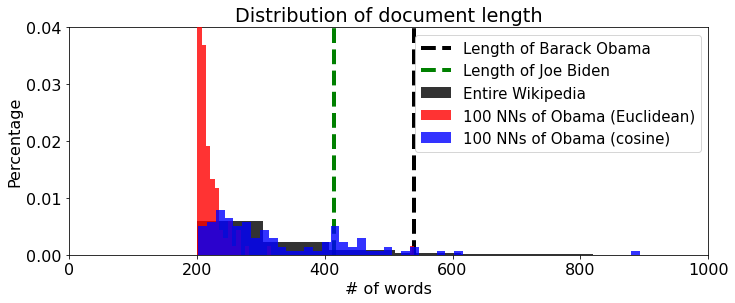

In [67]:
plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', density=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'][:100], 50, color='r', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'][:100], 50, color='b', edgecolor='None', histtype='stepfilled', density=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=wiki['length'][wiki.index[wiki['name'] == 'Barack Obama']].tolist()[0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki.index[wiki['name'] == 'Joe Biden']].tolist()[0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [68]:
tweet = {'act': 3.4597778278724887,
 'control': 3.721765211295327,
 'democratic': 3.1026721743330414,
 'governments': 4.167571323949673,
 'in': 0.0009654063501214492,
 'law': 2.4538226269605703,
 'popular': 2.764478952022998,
 'response': 4.261461747058352,
 'to': 0.04694493768179923}

In [69]:
word_indices = []
for word in tweet.keys():
    if word in map_index_to_word.keys():
        word_indices.append(map_index_to_word[word]  )

tweet_tf_idf = csr_matrix( (list(tweet.values()), ([0]*len(word_indices), word_indices)),
                          shape=(1, tf_idf.shape[1]) )

In [70]:
from sklearn.metrics.pairwise import cosine_distances

obama_tf_idf = tf_idf[35817]
print(cosine_distances(obama_tf_idf, tweet_tf_idf))

[[0.70591838]]


In [71]:
distances, indices = model2_tf_idf.kneighbors(obama_tf_idf, n_neighbors=10)
print(distances)

[[0.         0.70313868 0.7429819  0.7583584  0.77056123 0.7846775
  0.78803907 0.79092642 0.7983226  0.79946636]]
